In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Viewing the raw LIGO data

In [2]:
%matplotlib inline

from pycbc.catalog import Merger
import pylab

gw_150914 = Merger("GW150914")

data = {}

for ifo in ['H1', 'L1']:
    data[ifo] = gw_150914.strain(ifo)

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


# Entire 32 seconds of data round GW150914

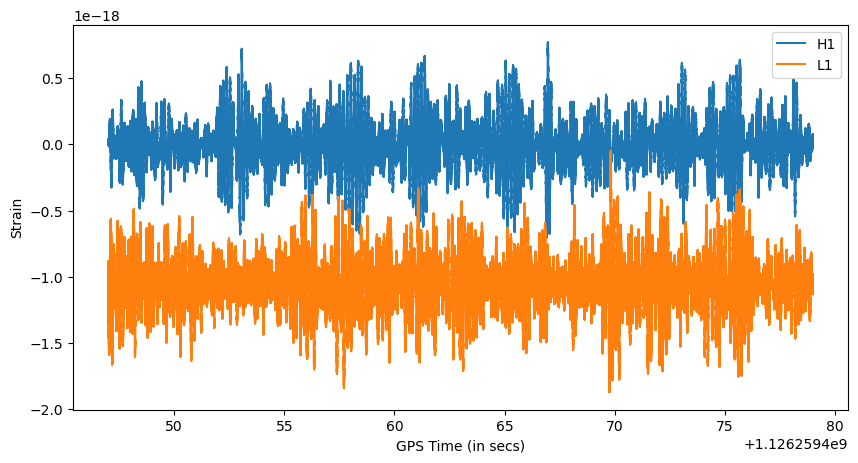

In [3]:
pylab.figure(figsize = (10, 5))

for ifo in data:
    pylab.plot(data[ifo].sample_times, data[ifo], label = ifo)
    
pylab.xlabel('GPS Time (in secs)')
pylab.ylabel('Strain')
pylab.legend()

pylab.show()

# Zoom into 1 second

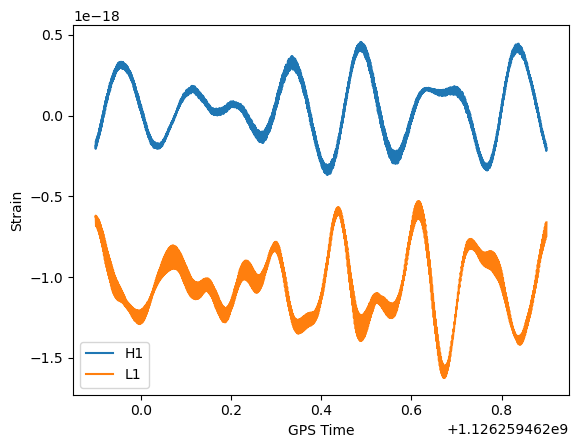

In [4]:
for ifo in data:
    zoom = data[ifo].time_slice(gw_150914.time - 0.5, gw_150914.time + 0.5)
    pylab.plot(zoom.sample_times, zoom, label = ifo)

pylab.xlabel('GPS Time')
pylab.ylabel('Strain')
pylab.legend()

pylab.show()

**When we just zoom into one second around GW150914, all you can see is the "low frequency behaviour" of the noise, since it is much louder than the higher frequency noise. (and signal)**

## Highpass the data to remove the low frequency content

**High-pass filters are often used to clean up low-frequency noise, remove humming sounds in audio signals, redirect higher frequency signals to appropriate speakers in sound systems, and remove low-frequency trends from time-series data, thereby highlighting the high-frequency trends.**

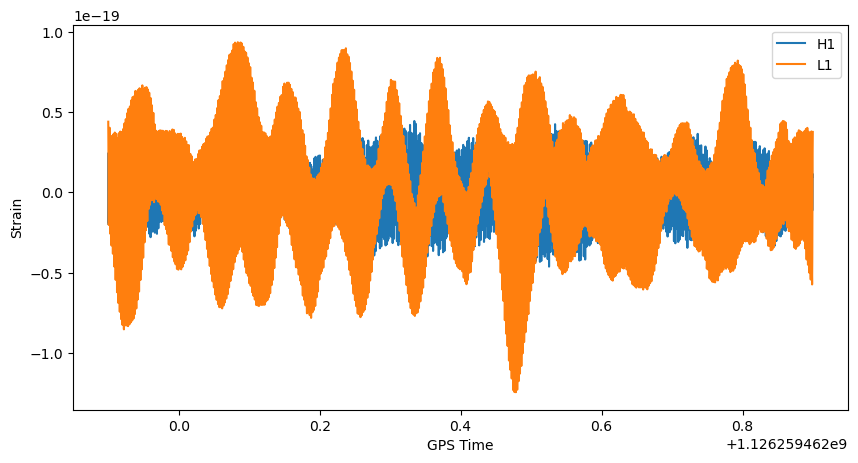

In [5]:
pylab.figure(figsize = (10, 5))

for ifo in data:
    
    # Highpass filter is used to supress the low frequency content of the data. We are using FIR filter.
    high_data = data[ifo].highpass_fir(15, 512) # (high pass freq, half sample length of highpass filter)
    
    zoom = high_data.time_slice(gw_150914.time - 0.5, gw_150914.time + 0.5)
    pylab.plot(zoom.sample_times, zoom, label = ifo)

pylab.xlabel('GPS Time')
pylab.ylabel('Strain')
pylab.legend()

pylab.show()

# Power Spectral Density

**Understanding how the noise varies over frequency is important for LIGO data analysis. <br>The power spectrum of a time series describes the distribution of power into frequency components composing that signal. <br>According to Fourier analysis, any physical signal can be decomposed into a number of discrete frequencies, or a spectrum of frequencies over a continuous range.**

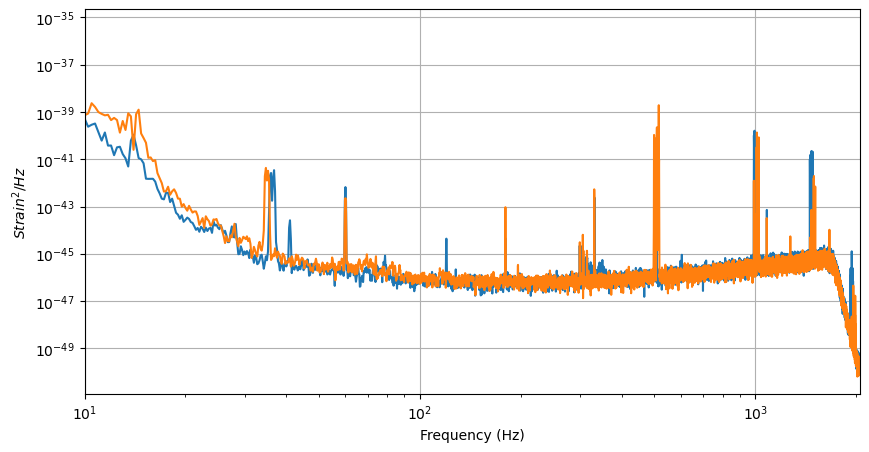

In [6]:
pylab.figure(figsize = (10, 5))
for ifo in data:
    
    # This estimates the PSD by sub-dividing the data into overlapping 4s long segments. (See Welch's method)
    psd = data[ifo].psd(4)
    
    # Note that the psd is a Frequency Series
    pylab.loglog(psd.sample_frequencies, psd)

pylab.xlabel('Frequency (Hz)')
pylab.ylabel('$Strain^2 / Hz$')
pylab.grid()
pylab.xlim(10, 2048)
pylab.show()

# Whitening the data

**To visualize the deviations from the noise, it is useful to "whiten" the data within some frequency range. In this way excesses in the data are visible as deviations from zero. <br>Whitening takes the data and attempts to make the power spectral density flat, so that all frequencies contribute equally.**

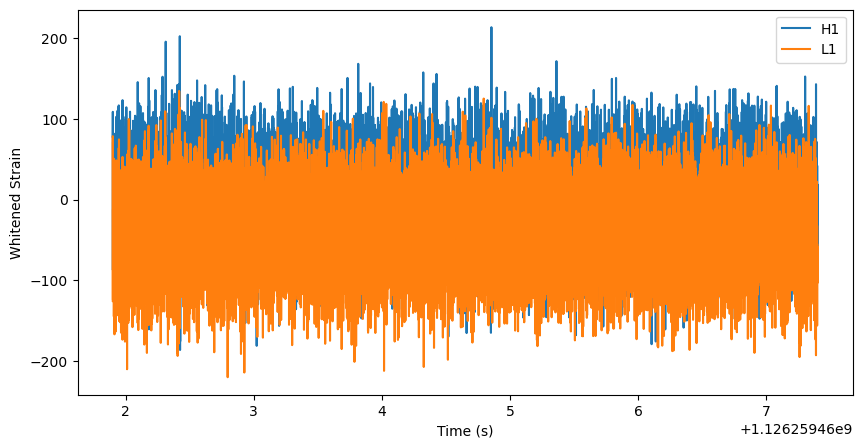

In [7]:
pylab.figure(figsize = (10, 5))

# Whiten the data
whitened = {}

for ifo in data:
    # (1) The first option sets the duration in seconds of each
    #     sample of the data used as part of the PSD estimate.
    # (2) The second option sets the duration of the filter to apply
    whitened[ifo] = data[ifo].whiten(4, 4) # (duration in secs of each sample of the data used as part of the psd estimate, duration of filter to apply)
    
    zoom = whitened[ifo].time_slice(gw_150914.time - 0.5, gw_150914.time + 5)
    pylab.plot(zoom.sample_times, zoom, label = ifo)

pylab.xlabel('Time (s)')
pylab.ylabel('Whitened Strain')
pylab.legend()
pylab.show()

In [8]:
# WHITEN THE DATA AND PLOT PSD - PENDING

## Bandpass the data of the merger between 30-150HZ.

**This will remove frequencies ranges which won't contribute to this kind of signal and make it possible to see the signal in question.**

**Bandpass filter allows only those electric waves lying within in a certain range, or band, of frequencies to pass and blocks all others.**

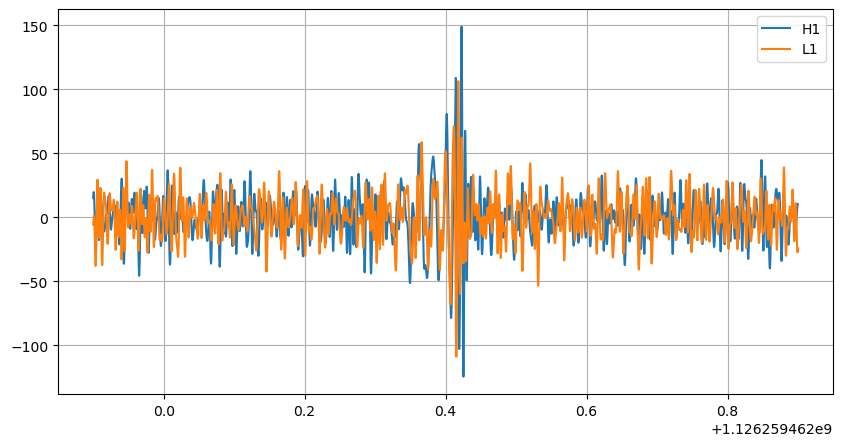

In [9]:
pylab.figure(figsize = (10, 5))

for ifo in whitened:
    
    # Apply a high pass filter (at 30Hz) followed by an lowpass filter (at 250Hz)
    bpsd = whitened[ifo].highpass_fir(30, 512).lowpass_fir(250, 512)
    
    zoom = bpsd.time_slice(gw_150914.time - 0.5, gw_150914.time + 0.5)
    pylab.plot(zoom.sample_times, zoom, label = ifo)
    
pylab.grid()
pylab.legend()
pylab.show()

### Focusing the plot around GW150914

**In the above plot we can see that there is some excess signal that sticks above the noise. Let's zoom in around this time now, and align the two time series.**

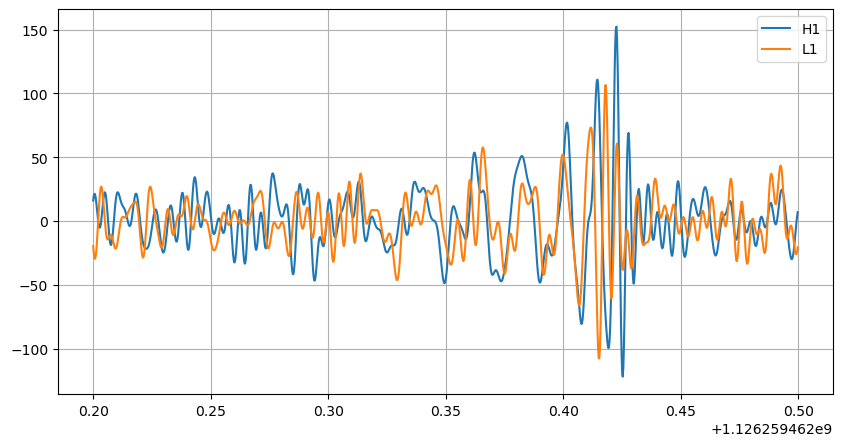

In [10]:
pylab.figure(figsize = (10, 5))

for ifo in whitened:
    
    bpsd = whitened[ifo].highpass_fir(20, 512).lowpass_fir(250, 512)
    zoom = bpsd.time_slice(gw_150914.time - 0.2, gw_150914.time + 0.1)
    pylab.plot(zoom.sample_times, zoom, label = ifo)

pylab.grid()
pylab.legend()
pylab.show()

**We can now see that there is a coherent signal that matches in phase for a few cycles, which ends at about 0.44 on the plot above.**

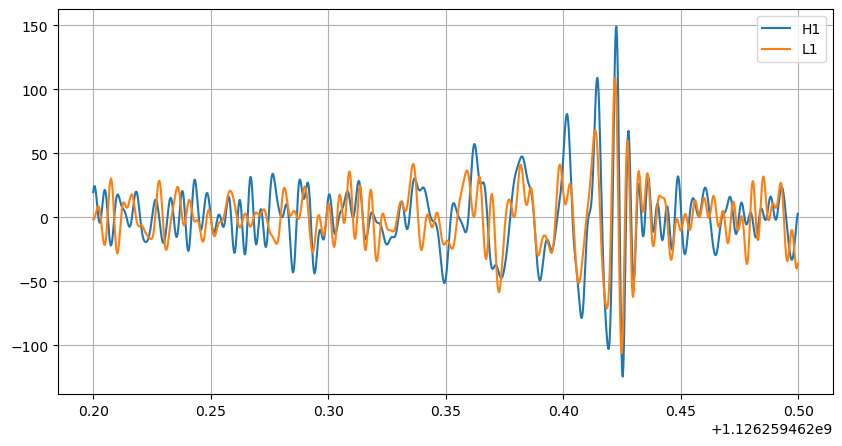

In [11]:
pylab.figure(figsize = (10, 5))

for ifo in whitened:
    bpsd = whitened[ifo].highpass_fir(30, 512).lowpass_fir(250, 512)
    
    if ifo == 'L1':
        bpsd.roll(int(bpsd.sample_rate * 0.007)) # 0.007 because signal was ~7ms seperated from the detectors
        bpsd *= -1
    
    # We will choose tighter zoom here.
    zoom = bpsd.time_slice(gw_150914.time - 0.2, gw_150914.time + 0.1)
    pylab.plot(zoom.sample_times, zoom, label = ifo)

pylab.grid()
pylab.legend()
pylab.show()

# Visualizing excesses in the data with a Q-transform plot

**A common way to visualize gravitational-wave data is with a time-frequency representation known as "constant-Q transform. <br> It is similar to a standard spectogram made with short-time Fourier transforms with the advantage that frequency bins are mostly sparselt spaced at high frequencies."**

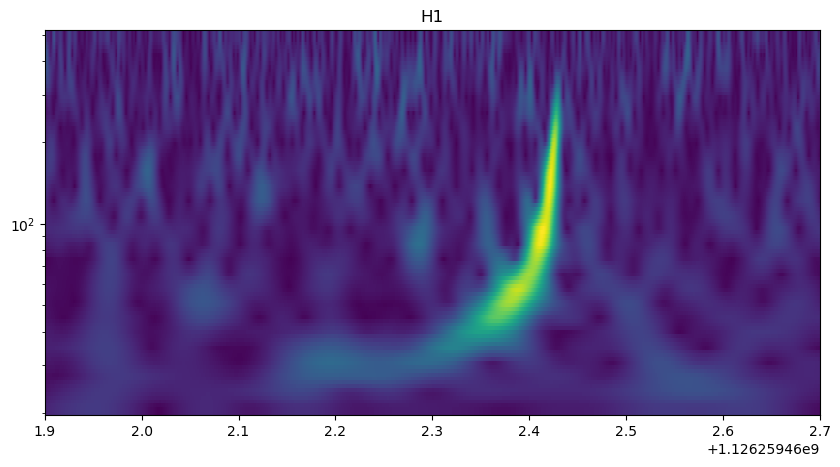

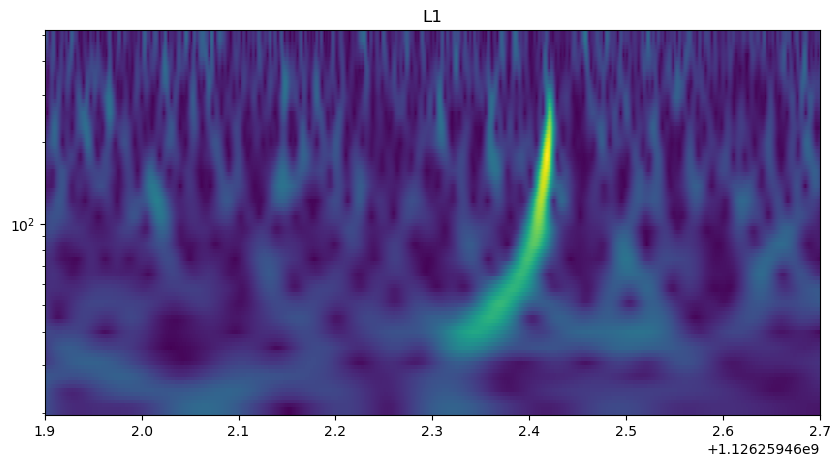

In [12]:
for ifo in whitened:
    # We'll choose a tighter zoom here.
    zoom = whitened[ifo].time_slice(gw_150914.time - 5, gw_150914.time + 5)
    
    # The options here:
    # (1) The time spacing for the output image (i.e. 1 ms in this case)
    # (2) The number of frequency bins in the output, logarithmically spaced
    # (3) The qrange to maximize over. We'll pick a constant at 8 here
    #     Typically higher values will be more appropriate for longer duration
    #     signals
    # (4) The frequency range to output
    times, freqs, power = zoom.qtransform(.001, logfsteps=100,
                                                qrange=(8, 8),
                                                frange=(20, 512),
                                         )
    pylab.figure(figsize = (10, 5))
    pylab.pcolormesh(times, freqs, power**0.5)
    pylab.xlim(gw_150914.time - 0.5, gw_150914.time + 0.3)
    pylab.title(ifo)
    pylab.yscale('log')
    pylab.show()